# 1. Specify the system type

In [4]:
import warnings
warnings.filterwarnings("ignore")

# specify the system

from RBG_Maxwell.Collision_database.select_system import which_system

plasma_system = 'Ncs_system'
which_system(plasma_system)
from numpy.random import uniform
from RBG_Maxwell.Collision_database.Ncs_system.collision_type import collision_type_for_all_species

import ray
ray.shutdown()
ray.init(_temp_dir='/data/smy')

2024-05-27 21:58:49,812	INFO worker.py:1622 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.7.13
Ray version:,2.4.0
Dashboard:,http://127.0.0.1:8265


# 2. Specify the coefficient for unit conversion 

In [5]:
from RBG_Maxwell.Unit_conversion.main import determine_coefficient_for_unit_conversion, unit_conversion
import numpy as np

In [6]:
# here we use a pure electron system
# the relavant PIC code is given by Jian-Nan Chen

# give the quantities in SI
# the spatial grid is chosen to be dx=dy=dz=10**(-4) m
# dx = dy = dz = float(3*10**(-5))
dx = dy = dz = 0.001


# v_max = 48694781
v_max = 2234262
# v_max = 5.047585915196952*10**(17)

# maximum momentum
# momentum = float(4.43*10**(-23)) 
momentum = float(9.10938356*10**(-31)*v_max) 

# the momentum grid is set to be 
# half_px=half_pz=half_py=momentum
npx, npy, npz= 6, 6, 6
nx, ny, nz = 41, 41, 41

T_K = 116045

dpx = float(2*momentum/npx)
dpy = float(2*momentum/npy)
dpz = float(2*momentum/npz)
dp_volume = float(dpx*dpy*dpz)
dp = float((dpx+dpy+dpz)/3)

# time scale
dt = float(1*10**(-10))

# number of maximum particles in each phase grid
n_max = float(1*10**(5))

# number of averaged particles in each spatial grid
n_average = float(10**(5)/(60))

E = float(100)
B = float(0)

# Now find the coefficient
hbar, c, lambdax, epsilon0 = determine_coefficient_for_unit_conversion(dt, dx, dx*dy*dz, dp, dp_volume,\
                                                                       n_max, n_average, v_max, E, B)

Searching for proper scaling parameters...
This may take several minutes.


In [4]:
print("hbar: ",hbar)
print("c:     %.1e"%c)
print("lambdax: ",lambdax)
print("epsilon0: ",epsilon0)

hbar:  0.001
c:     1.0e+09
lambdax:  1e-27
epsilon0:  1e-13


In [5]:
conversion_table = \
unit_conversion('SI_to_LHQCD', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)
conversion_table_reverse = \
unit_conversion('LHQCD_to_SI', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)

# 3. Specify the configurations for plasma evolution

In [6]:
# import the main class Plasma
from RBG_Maxwell.Plasma.main import Plasma
import math

In [7]:
# time step, and spatial infinitesimals
dt, dx, dy, dz = float(dt*conversion_table['second']),\
                 float(dx*conversion_table['meter']), \
                 float(dy*conversion_table['meter']), \
                 float(dz*conversion_table['meter'])

T = float(T_K *conversion_table['Kelvin'])
# we have only one type of particle e-
num_particle_species = 1


# treat the electron as classical particles
particle_type = np.array([0])


# masses, charges and degenericies are
masses, charges, degeneracy = np.array([float(9.10938356*10**(-31)*conversion_table['kilogram'])]), \
                              np.array([float(-1.602176634*10**(-19)*conversion_table['Coulomb'])]),\
                              np.array([1])


# momentum grids5
npx, npy, npz = np.array([6]),np.array([6]),np.array([6])


# momentum range for y and z direction are not import in this case
half_px, half_py, half_pz = np.array([float(9.10938356*10**(-31)*v_max*conversion_table['momentum'])]), \
                            np.array([float(9.10938356*10**(-31)*v_max*conversion_table['momentum'])]),\
                            np.array([float(9.10938356*10**(-31)*v_max*conversion_table['momentum'])])


dpx, dpy, dpz = 2*half_px/npx, 2*half_py/npy, 2*half_pz/npz


# cpu caculation matrix
d_sigma = float(2.01765*10**(9)*conversion_table['meter']**2)

m1 = masses[0]



# load the collision matrix
flavor, collision_type, particle_order = collision_type_for_all_species()
expected_collision_type = ['2TO2']

# 4. Specify the parallel configuration for plasma evolution

In [8]:
# number of spatial grids
# must be integers and lists
# odd numbers are recomended
# the maximum spatial gird is limited by CUDA, it's about nx*ny*nz~30000 for each card
nx_o, ny_o, nz_o = [nx], [ny], [nz]

# value of the left boundary
# this is the 
x_left_bound_o, y_left_bound_o, z_left_bound_o = [-nx/2*dx],\
                                                 [-ny/2*dy],\
                                                 [-nz/2*dz]

# number samples gives the number of sample points in MC integration
num_samples = 10000

# Only specify one spatial region
number_regions = 1

# each spatial should use the full GPU, this number can be fractional if many regions are chosen
# and only one GPU is available
num_gpus_for_each_region = 1

time_stride_back = 10
# since only one region is specified, this will be empty
sub_region_relations = {'indicator': [[],[],[],[]],\
                        'position': [[]]}

# if np.ones are used, the boundaries are absorbing boundaries
# if np.zeros are used, it is reflection boundary
# numbers in between is also allowed
boundary_configuration = {}
for i_reg in range(number_regions):
    bound_x = np.ones([ny_o[i_reg], nz_o[i_reg]])
    bound_y = np.ones([nz_o[i_reg], nx_o[i_reg]])
    bound_z = np.ones([nx_o[i_reg], ny_o[i_reg]])
    boundary_configuration[i_reg] = (bound_x, bound_y, bound_z)

# 5. Specify the initial and boundary condition for plasma evolution

## Source term distribution

In [9]:
from numba import jit
num_momentum_levels = 1

# iniital distribution function
f = {}
f_middle = np.zeros([nx_o[i_reg], ny_o[i_reg], nz_o[i_reg], npx[0], npy[0], npz[0]])
for i_reg in range(number_regions):
    f[i_reg] = np.zeros([num_momentum_levels, num_particle_species,\
                         nx_o[i_reg], ny_o[i_reg], nz_o[i_reg], npx[0], npy[0], npz[0]])

# the momentum distribution is a Gaussian function
phase_space_volume = dx*dy*dz*dpx*dpy*dpz
@jit
def setup1(npx,npy,npz,nx_o,ny_o,nz_o,f,r_v,p_v):
    for ix in range(nx_o[0]):
        for iy in range(ny_o[0]):
            for iz in range(nz_o[0]):                       
                # current velocity
                f[ix,iy,iz] = r_v[ix,iy,iz]*p_v
    return f

# f_0

In [10]:
number_particle = 1*10**18*nx*ny*nz*(dx*conversion_table_reverse['TO_meter'])**3
delta_n = 10**(17)
k = 2 * np.pi / (nx*dx)  # 波数    

In [11]:
import math
import random
v_collect = np.zeros([npx[0],npy[0],npz[0]])
for ipx in range(npx[0]):
    x = ipx - int(npx[0]/2)
    for ipy in range(npy[0]):
        y = ipy - int(npy[0]/2)
        for ipz in range(npz[0]):
            z = ipz - int(npz[0]/2)
            v = math.sqrt(x**2+y**2+z**2)
            v_collect[ipx, ipy, ipz] = v
sigma = 7
p_v = 1/math.sqrt(2*math.pi*sigma**2)*np.exp(-(np.array(v_collect))**2/(2*sigma**2))
p_v = p_v/p_v.sum()

In [12]:
r_collect = np.zeros([nx_o[0],ny_o[0],nz_o[0]])
for ix in range(nx_o[0]):
    x = ix - int(nx_o[0]/2)
    for iy in range(ny_o[0]):
        y = iy - int(ny_o[0]/2)
        for iz in range(nz_o[0]):
            z = iz - int(nz_o[0]/2)
            r = math.sqrt(x**2+y**2+z**2)
            r_collect[ix, iy, iz] = r
sigma = 10
r_v = 1/math.sqrt(2*math.pi*sigma**2)*np.exp(-(np.array(r_collect))**2/(2*sigma**2))
r_v = r_v/r_v.sum() * number_particle

In [13]:
f[0][0][0] = setup1(npx[0],npy[0],npz[0],nx_o,ny_o,nz_o,f[0][0][0],r_v,p_v)

In [ ]:
f[0][0][0].sum()

In [ ]:
f[0][0][0].sum()*dx*dy*dz*dpx[0]*dpy[0]*dpz[0]

## Distribution conversion

In [22]:
# reshape the distribution function in different regions
for i_reg in range(number_regions):
    f[i_reg] = f[i_reg].reshape([num_momentum_levels, num_particle_species,\
                                 nx_o[i_reg]*ny_o[i_reg]*nz_o[i_reg]*npx[0]*npy[0]*npz[0]])

'''
We add an external magnetic field of 10 T in the +y direction
'''
BBx = BBy = BEz = np.zeros((20,20,20))
for i in range(20):
    for j in range(20):
        for k in range(20):
            BBx[i,j,k] = 3*10**(-1)*math.sin(i)*conversion_table['Tesla']
            BBy[i,j,k] = 3*10**(-1)*math.sin(j)*conversion_table['Tesla']
            BEz[i,j,k] = 3*10**(-1)*math.sin(k)*conversion_table['Volt/m']
            
BBz,BEy, BEx = [0*np.ones(nx_o[0]*ny_o[0]*nz_o[0])],[0*np.ones(nx_o[0]*ny_o[0]*nz_o[0])],[0*np.ones(nx_o[0]*ny_o[0]*nz_o[0])]
BBx = np.array(BBx).flatten()
BBy = np.array(BBy).flatten()
BBz = np.array(BBz).flatten()
BEx = np.array(BEx).flatten()
BEy = np.array(BEy).flatten()
BEz = np.array(BEz).flatten()
# BBx = [(2.9*10**(-5))*conversion_table['Tesla']*np.ones(nx_o[0]*ny_o[0]*nz_o[0])]
# BBy = [(1*10**(-6))*conversion_table['Tesla']*np.ones(nx_o[0]*ny_o[0]*nz_o[0])]
# BBz = [0]
# BBx, BBy, BBz = [0],[0],[0]
# BEx, BEy, BEz = [0],[0],[0]


In [23]:
plasma = Plasma(f, dt,\
                nx_o, ny_o, nz_o, dx, dy, dz, boundary_configuration, \
                x_left_bound_o, y_left_bound_o, z_left_bound_o, \
                int(npx[0]), int(npy[0]), int(npz[0]), half_px, half_py, half_pz,\
                masses, charges, sub_region_relations,\
                flavor, collision_type, particle_type,\
                degeneracy, expected_collision_type,\
                num_gpus_for_each_region,\
                hbar, c, lambdax, epsilon0,\
                num_samples = 100, drift_order = 1,\
                rho_J_method="raw", GPU_ids_for_each_region = ["0"])

[100]


# 6. Perform evolution 

In [24]:
n_step = 4001
number_rho = []
EM = []
charged_rho = []
dis = []
VT= []
DT = []
CT = []
real_time = []
import time
start_time = time.time()
for i_time in range(n_step):
    if i_time%200 == 0:
        print('Updating the {}-th time step - dis'.format(i_time))
        dis.append(plasma.acquire_values("Distribution"))
        
    plasma.proceed_one_step(i_time, n_step, processes = {'VT':1., 'DT':1., 'CT':0.},\
                            BEx = BEx, BEy = BEy, BEz = BEz, BBx = BBx, BBy = BBy, BBz = BBz)  
    if i_time%200 == 0:
        print('Updating the {}-th time step - number_rho'.format(i_time))
#         CT.append(plasma.acquire_values("Collision term"))
        number_rho.append(plasma.acquire_values("number_rho/J"))
#         real_time.append(plasma.get_realtime(i_time))
        charged_rho.append(plasma.acquire_values("Electric rho/J"))
    
#     number_rho.append(plasma.acquire_values("number_rho/J"))
    EM.append(plasma.acquire_values('EM fields on current region'))
    
#     if EM[i_time][0][0].max() == 0 and i_time>=10:
#         print(i_time)
#         break
#     real_time = plasma.get_realtime(i_time)
#     print(real_time)
end_time = time.time()
print((end_time-start_time)/3600,'hours')

Updating the 0-th time step - dis
(Plasma_single_GPU pid=1879526) Using context GPU-984fe1ca-3588-586d-fc7f-8c0c1f8183c4 for region 0.
Updating the 0-th time step - number_rho
Updating the 200-th time step - dis
Updating the 200-th time step - number_rho
Updating the 400-th time step - dis
Updating the 400-th time step - number_rho
Updating the 600-th time step - dis
Updating the 600-th time step - number_rho
Updating the 800-th time step - dis
Updating the 800-th time step - number_rho
Updating the 1000-th time step - dis
Updating the 1000-th time step - number_rho
Updating the 1200-th time step - dis
Updating the 1200-th time step - number_rho
Updating the 1400-th time step - dis
Updating the 1400-th time step - number_rho
Updating the 1600-th time step - dis
Updating the 1600-th time step - number_rho
Updating the 1800-th time step - dis
Updating the 1800-th time step - number_rho
Updating the 2000-th time step - dis
Updating the 2000-th time step - number_rho
Updating the 2200-th t

# 7. Results

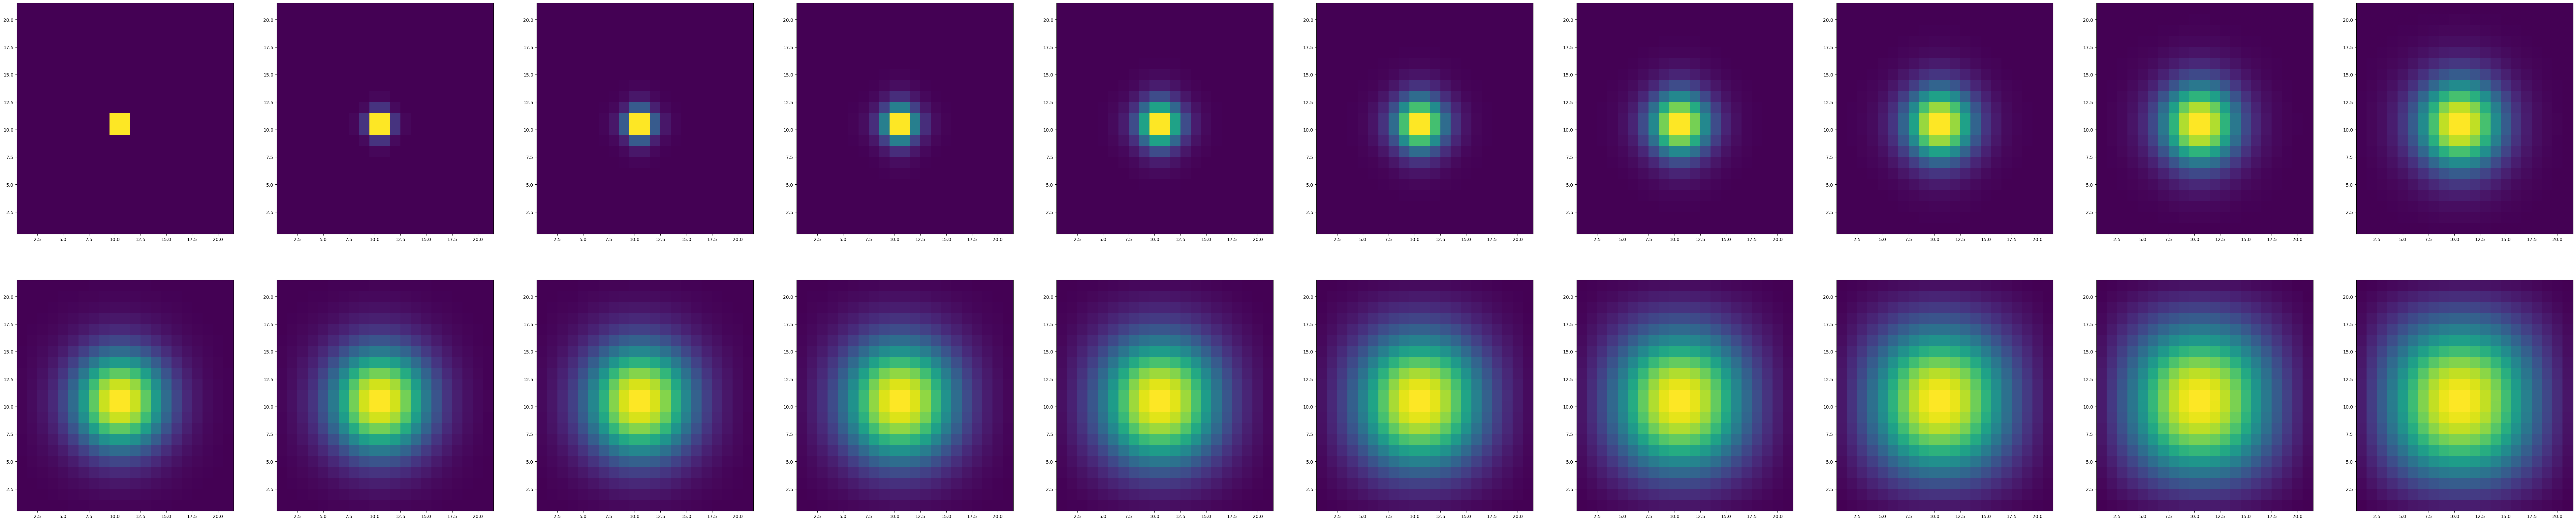

In [221]:
# spatial distribution
import matplotlib.pyplot as plt
xi, yi = np.mgrid[1:22:1,1:22:1]
fig, axes = plt.subplots(ncols=10, nrows=2, figsize = (100,20))

for jj in range(2):
    for kk in range(10):
#         axes[jj,kk].pcolormesh(xi, yi, dis[(jj*10+kk)][0][0][1].reshape([nx_o[0],ny_o[0],nz_o[0],npx[0],npy[0],npz[0]])[1000:1500,2,2,:].sum(axis=(-1,-2)))
        axes[jj,kk].pcolormesh(xi, yi, dis[(jj*10+kk)][0][0][0].reshape([nx_o[0],ny_o[0],nz_o[0],npx[0],npy[0],npz[0]])[:,:,10].sum(axis=(-1,-2,-3)))

In [ ]:
# spatial distribution
import matplotlib.pyplot as plt
xi, yi = np.mgrid[1:21:1,1:21:1]
fig, axes = plt.subplots(ncols=10, nrows=3, figsize = (100,30))
for jj in range(3):
    for kk in range(10):
        axes[jj,kk].pcolormesh(xi, yi, EM[(jj*300+kk*10)][0][0].reshape([nx_o[0],ny_o[0],nz_o[0]]).sum(axis=-1))

In [219]:
EM_t = np.zeros((len(EM),nx_o[0], ny_o[0], nz_o[0]))
for i in range(len(EM)):
    EM_t[i] = EM[i][0][0].reshape((nx_o[0], ny_o[0], nz_o[0]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 定义常量
k_B = 1.380649e-23  # 玻尔兹曼常数（J/K）
m_e = 9.10938356e-31  # 电子质量（kg）
e = 1.602176634e-19  # 基本电荷（C）
epsilon_0 = 8.854187817e-12  # 真空介电常数（F/m）
c = 3e8  # 光速（m/s）

# 定义参数
n = 1e18  # 电子密度（m^-3）
T_e = 1e1  # 电子温度（eV）
B0 = 20  # 外加磁场强度（T）

# 计算热速度和等离子体频率
v_th = np.sqrt(k_B * T_e / m_e)
omega_pe = np.sqrt(n * e**2 / (epsilon_0 * m_e))
omega_ce = e * B0 / m_e

# 定义波数范围
k_values = np.linspace(1, 1e7, 1000)  # 波数数组（m^-1）

# 计算色散关系
omega_o = np.sqrt(omega_pe**2 + 3 * k_values**2 * v_th**2)  # O波的角频率

# 将角频率转换为频率
f_o = omega_o / (2 * np.pi)  # O波的频率

# 绘制色散关系
plt.figure(figsize=(10, 6))

plt.plot(k_values, f_o, label=r'O mode ($f_o$)')

plt.xlabel(r'Wave number $k$ (m$^{-1}$)')
plt.ylabel(r'Frequency $f$ (Hz)')
plt.title('Dispersion Relation in Magnetized Plasma')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftn, fftshift

dx = dy = dz = 0.000001
dt = float(1*10**(-10))

# 假设我们有以下模拟数据
# 对时间进行傅里叶变换
E_field_freq = fft(EM_t, axis=0)
frequencies = fftfreq(len(EM), dt)


positive_frequencies = frequencies[frequencies >= 0]

E_field_freq = E_field_freq[frequencies >= 0]

# 对空间进行傅里叶变换
E_field_komega = fftshift(fftn(E_field_freq, axes=(1, 2, 3)), axes=(1, 2, 3))
kxs = fftshift(fftfreq(nx, dx))
kys = fftshift(fftfreq(ny, dy))
kzs = fftshift(fftfreq(nz, dz))

# 计算频谱强度
intensity = np.abs(E_field_komega)**2

# 合并波数分量
Kx, Ky, Kz = np.meshgrid(kxs, kys, kzs, indexing='ij')
k_magnitude = np.sqrt(Kx**2 + Ky**2 + Kz**2)

# 对频谱强度进行处理，得到二维的频率和波数关系
num_k_points = 10**7  # 设置波数点的数量
k_unique = np.linspace(k_magnitude.min(), k_magnitude.max(), num=num_k_points)

k_range = 0.1  # 调整掩码范围大小
dominant_frequencies = np.zeros(len(k_unique))

for j, k_val in enumerate(k_unique):
    mask = (k_magnitude >= k_val - k_range) & (k_magnitude < k_val + k_range)
    if np.any(mask):
        # 使用加权平均方法选择频率
        intensities_masked = np.sum(intensity[:, mask], axis=1)
        if np.sum(intensities_masked) != 0:
            dominant_frequencies[j] = np.sum(positive_frequencies * intensities_masked) / np.sum(intensities_masked)



# 绘制色散关系折线图
plt.plot(k_unique, dominant_frequencies, marker='o', linestyle='-')
plt.plot(k_values, omega)a
plt.xlabel('Wavenumber (|k|)')
plt.ylabel('Frequency (ω)')
plt.title('Dispersion Relation')
plt.grid(True)

